## 第三章
* 第二章介绍了最为简单的深度学习网络：单层的线性神经网络，本质上这样的线性计算方式无法提供较为复杂的建模能力，但是一切复杂网络结构的基础，针对这类结构简单的线性网络，本章设计了两类任务：线性回归和softmax回归


### 3.1 线性回归

**回归**是能为一个或多个自变量与因变量之间关系建模的一类方法。深度学习所解决的很多问题都可以建模为回归类型，**线性回归**作为最为简单和流行的回归类型，有几个基础的假设：线性回归中自变量和因变量之间的关系是线性的；另外，线性回归中允许观测值中包含一些噪声，这些噪声都比较正常，例如遵循正态分布。  
书中给出的线性回归的例子是房价预测，此时因变量的房价会同时受到两个自变量房屋面积和房龄两个因素的影响，因此整体的数学模型可以表示为两个自变量的线性组合加上随机分布的噪声得到房价，如果将这个例子推广到高维情况，就可以得到线性回归的数学表达形式：  
$$
\hat{y} = \mathbf{w^T}\mathbf{x} + b
$$  
在这个式子中，x和y对应着单个数据样本的特征和观测值，即x的维度就是特征的个数，但在深度学习的场景中，需要通过多个数据样本学习线性回归的模型，因此将上面的公式改写为如下形式：  
$$
\mathbf{\hat{y}} = \mathbf{X}\mathbf{w} + b
$$  
在这个式子中的$\mathbf{X}$的每一行对应着一个数据样本，每一列对应着一个特征类型  
此时我们再次回顾线性回归的出发点，我们的目标是寻找和识别一个符合这个线性回归模型的模式，因此问题的关键变成了如何寻找公式中的**权重矩阵** ，根据之前学过的一些知识，我们自然的想到了通过真实数据集确定一个最接近真实的权重矩阵，在寻找这样的模型参数之前，还需要引入两个概念：一种衡量模型参数学习质量的方式；一种能够更新模型参数以提高模型预测质量的方法  
**损失函数**就是上面提到的模型质量的度量方式，针对特定的问题，需要设计符合当前问题的损失函数，通常将损失函数定义为数值越小损失越小，完美预测的损失为0。一种常见的损失函数就是平方损失函数：  
$$
L(\mathbf{w},b) = \frac{1}{n}\sum_{i=1}^{n}l^{(i)}(\mathbf{w},b) = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(\hat{y}^{(i)} - y^{(i)})^2 = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(\mathbf{w}^T\mathbf{x}^{(i)} + b - y^{(i)})^2
$$  
上述公式中的$y^{(i)}$代表真实的标签数据，$\hat{y}^{(i)}$代表预测的标签数据，在上述loss计算中共计n个数据样本，均值的损失函数设计从某种程度上代表了模型在整个数据集上的预测质量，因此我们可以通过上述损失函数寻找最符合预期的模型参数，即：  
$$
\mathbf{w}^*, b^* = \argmin_{\mathbf{w},b} L(\mathbf{w},b)
$$  
d2l书在这里提到了解析解的概念，其实这里不了解也没关系，如果硬要说的话，就是线性回归这样一个任务有解析解的形式，解析解的形式建立在$X$有列满秩的性质，即在众多的数据样本中的各种特征的分布是不同的，这个概念是显然的，因为如果整理数据必然不可能会出现不同特征的表现相同的情况，因此完全可以通过最小二乘解的唯一形式写出线性回归的解析解，但其实在考虑引入噪声的情况下，线性回归大概率是不存在解析解的  
**优化策略**同样是学习最佳模型参数的一个重要层面，d2l在这里介绍的优化策略是最常见的一种优化算法——梯度下降、小批量随机梯度下降(minibatch stochastic gradient descent),这里我们选择和d2l书中不同的解释方式来说明这个优化算法的想法(不看公式)：在确定一个损失函数后，我们有一个很简单和很深刻的认知是：如果我们去计算损失函数关于这些模型参数的梯度，这个梯度的方向代表着在某一个优化位置的当前最佳优化方向(梯度向量的范数只能代表在单位变化下的函数变化情况)，如果让模型参数朝着相反着梯度的方向进行优化，理论上就可以让损失函数朝着当前的方向以最快速率下降，因此称为梯度下降，在单次迭代中，所有的数据样本都会参与梯度计算，整体的优化方向需要受到所有数据样本的影响，因此Pytorch中随机抽取一小批样本，在反向梯度的基础上乘以一个预先确定的学习率$\eta$，这类似优化算法中的步长(另外在批次中反向梯度取均值)即为小批量随机梯度下降

In [1]:
# 在正式开始介绍神经网络之前，d2l用一个小章节说明了在pytorch中通过tensor矢量化加速计算

import time
import math
import numpy as np
import torch

# 这里设置两个1000维的向量进行加法运算
ndim = 1000
a = torch.ones(ndim)
b = torch.ones(ndim)

# 下面这个类借助time模块计算运算时长
class Timer:
    def __init__(self):
        self.time = []
        self.start()

    def start(self):
        self.tik = time.time()
    
    def stop(self):
        self.time.append(time.time()-self.tik)
        return self.time[-1]
    
    def avg(self):
        return sum(self.time) / len(self.time)
    
    def sum(self):
        return sum(self.time)
    
    def cumsum(self):
        return np.array(self.time).cumsum().tolist()
    
c = torch.zeros(ndim)
timer = Timer()
for i in range(ndim):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec') # 0.00812 sec

timer.start()
d = a + b 
print(f'{timer.stop():.5f} sec') # 0.00010 sec,计算时间大大缩短说明了矢量化计算的好处

    

0.00282 sec
0.00019 sec


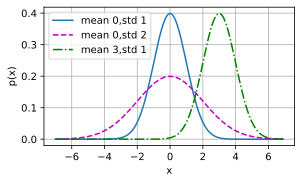

In [ ]:
# 下面的内容可以帮助从数学角度分析平方损失函数为何能作为一类经典基础的损失函数类型
# 将原生的数据定义为符合正态分布
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return (p * np.exp(-0.5 * (x - mu)**2 / sigma ** 2 ))

x = np.arange(-7,7,0.1) # 这里展开说说arange和linspace的不同，arange的用法是常见参数顺序：开始点，结束点(左闭右开)，间隔长度；linspace的用法是常见参数顺序：开始点，结束点(左闭右闭)，总点数(所有离散点的个数)
params = [(0,1), (0,2), (3,1)]
# 这里画图用到了之前定义的画图函数，我们只能把第二章的画图函数再定义一遍

def use_display():
    backend_inline.set_matplotlib_formats("svg")
# backend_inline是IPython库的一个模块，主要作用是控制matplotlib图表的显示方式，设置的"svg"是一种矢量图格式，svg是一种基于XML的矢量图形格式，与"png"等位图格式不同，矢量图形格式可以做到无损缩放，但渲染复杂图形时消耗资源更多


def set_figsize(figsize = [3.5,2.5]):
    use_display()
    plt.rcParams["figure.figsize"] = figsize


def set_axes(axes,xlabel,ylabel,xscale,yscale,xlim,ylim,legend=None):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.grid()
    if legend:
        axes.legend(legend)

# 上述的所有格式设置都是为了下面的plot函数服务，plot函数考虑了这样几种情况：只有y轴方向的数据，这意味着x轴坐标可能不重要，默认赋值为[0,n-1];在相同的x轴取值下，同时画出多条函数曲线

def plot(X, Y=None, xlabel=None, ylabel=None, xscale='linear', yscale='linear', xlim=None, ylim=None, fmts=('-','m--','g-.','r:'), figsize=(3.5,2.5), axes=None, legend=None):
    # fmts中指定了四种绘图格式，默认的plot曲线颜色为蓝色，'-'也是默认格式，表示实线，‘--’表示虚线，‘-.’表示点划线，':'表示点线
    if legend is None:
        legend = []
    
    set_figsize(figsize)
    axes = axes if axes else plt.gca() # 未指定特定的绘图axes就选择当前的axes

    def has_oneaxis(x):
        if hasattr(x,"ndim") and x.ndim == 1 or isinstance(x,list) and not hasattr(x[0],"__len__"):
            return True
    # 这里的函数判断了两类情况，首先如果不是普通的list，那指定ndim==1确定了只会是一维的计算单元；如果是list类型，则x[0]没有'__len__'使得也不会出现二维以上的多维情况

    if has_oneaxis(X):
        X = [X] # 不管在调用plot函数时有没有指定y，这样的操作都会在原来的x基础上再套一个[],使得原来一维的计算单元变成了[1,n]这样的结构，这样的主要原因是为了配合后面的多组同时绘制

    if Y is None:
        X, Y = [[]] * len(X), X # 主要是为了处理未指定Y的情况,首先会执行将X的值赋给Y，再将X设置为对应长度的[]，这里设置对应长度主要是为了配合zip的解包
    elif has_oneaxis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()

    for x,y,fmt in zip(X,Y,fmts):
        if len(x):
            plt.plot(x,y,fmt)
        else:
            plt.plot(y,fmt)
    
    set_axes(axes,xlabel,ylabel,xscale,yscale,xlim,ylim,legend)


plot(x,[normal(x,mu,sigma) for mu,sigma in params], xlabel='x', ylabel='p(x)', figsize = (4.5,2.5), legend=[f'mean {mu},std {std}' for mu,std in params])
# 这里需要注意语法问题，在循环参数不是唯一参数的情况下，需要在循环参数的外部添加圆括号和方括号


在对正态分布的数学形式有初步了解后，就可以对含有噪声的观测数据建模，观测数据的噪声服从均值为0的高斯分布，于是整个观测模型可以写成：  
$$
y = \mathbf{w}^T\mathbf{x} + b + \epsilon , \quad \epsilon \sim \mathcal{N}(0,\sigma^2)
$$  
不含噪声的部分作为均值存在，添加的噪声为观测数据提供方差，因此可以根据数据样本中的$\mathbf{x}$计算关于观测数据$\mathbf{x}$的概率分布，理论上来说，我们希望通过网络、损失函数和优化器计算得到对应的后验分布最大，即公式：  
$$
P(y|\mathbf{x}) = \frac{1}{\sqrt{2\pi\sigma^2}}exp(-\frac{1}{2\sigma^2}(y - \mathbf{w}^T\mathbf{x} - b)^2).\\
P(\mathbf{y}|\mathbf{x}) = \prod_{i=1}^np(y^{(i)}|\mathbf{x}^{(i)})
$$  
上述公式的成立代表着模型服从了真实的数据分布，如果按照损失函数在优化过程中越来越小的原则，我们可以去优化$P(\mathbf{y}|\mathbf{x})$的负对数，这样同样将后验分布作为指导模型参数优化方向的损失函数，这样我们就能得到下面的优化目标：  
$$
-\log{P(\mathbf{y}|\mathbf{x})} = \sum{i=1}_n\frac{1}{2}\log(2\pi\sigma^2) + \frac{1}{2\sigma^2}(y^{(i)} - \mathbf{w}^T\mathbf{x} - b)^2.
$$  
我们可以略微对上述优化目标加以分析，首先模型的优化目标是线性回归中的线性计算参数($\mathbf{w}$和$b$)，所以在上面的负对数优化目标中第一部分完全可以不关注，因为第一项跟这两项模型参数毫无关系，第二项的优化目标如果不考虑外面的系数，不就是我们之前一直在说的平方损失函数吗？至此，我们就得到了选择平方损失函数的理由，从概率分布上可以说明，当然平方损失函数的数学理解不应局限在高斯分布的假设当中，同时，其他的更加复杂的损失函数也可以用严密的数学方式证明其合理性。

我们在正式进入神经网络的编写前需要了解一些预备知识：
在我们的后面内容中，我们会涉及到神经网络在特定的上下文环境中运行，以及以什么样的模式来运行网络，常见的例子就是`with torch.no_grad():`和`model.train()`、`model.eval()`
with torch.no_grad()常用于参数更新和推理阶段，它的作用是关闭梯度跟踪，在with torch.no_grad()上下文管理器下，PyTorch不会记录张量操作的计算图，也不会自动计算梯度，这样也能节省内存和计算资源，避免因保留不必要的中间变量而导致的内存占用：因此在参数更新的场景下，参数更新只是单纯的数值操作，我们并不想把他加入到计算图中；推理类似，我们只需要用，并不再需要进行复杂的计算和生成计算图，但这个场景下可以使用更加精确的：with torch.inference_mode():，因为这个上下文中还可以禁用一些内部机制
model.eval()通常会和with.torch.no_grad():一起使用，这说明现在的网络处于评估模式，model.eval()通常发生在normalization和dropout中，为什么会有评估模式的出现呢：可以想象这两个方法的应用场景：batch normalization在训练的时候是根据单个batch中的数据来计算均值方差的，但在测试时只能去计算训练时总的均值和方差来等效替代测试数据中的这两项，再比如dropout中，训练时会随机地舍弃部分结点，但推理的时候就直接使用了所有的网络结点，也就是说，实际上测试模式和model.train()的出现会为了切换模型的行为  
上述两种情况解决的是**逻辑问题**，但with torch.no_grad()解决的是当前的操作是否要加入计算图，是否占用计算资源，解决的是**资源问题**，与with torch.no_grad()对应的是with torch.enable_grad();因此这两者还是有本质的差别，甚至在model.eval()中也可以with torch.enable_grad():    
推理时建议使用with torch.inference_mode():


### 3.2 线性回归的从零开始实现

In [42]:
# 从下面开始，即将从零实现线性回归，一个线性回归预测模型包括数据流水线、模型、损失函数、优化器等等，因此需要一部分一部分地去实现这些组件

# 下面是生成数据集和读取数据集的模块
import torch
import random
from matplotlib import pyplot as plt

def synthetic_data(w,b,num_examples):
    X = torch.randn((num_examples,len(w)))
    y = torch.mv(X,w) + b 
    y += torch.randn_like(y) * 0.01
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
num_examples = 1000
features, labels = synthetic_data(true_w,true_b,num_examples)
# plt.scatter(features[:,0].numpy(),labels.numpy(),1) # 1在这里表示的是散点图中散点的大小

def data_iter(batch_size, features, labels):
    num_examples = features.shape[0]
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # 这里转不转换成torch.tensor类型的索引都可以
        chosen_indices = indices[i:min(i+batch_size,num_examples)]
        # batch_indices = torch.tensor(chosen_indices)
        yield features[chosen_indices],labels[chosen_indices]
        # yield features[batch_indices], labels[batch_indices] 

# 下面是模型定义和模型参数初始化
w = torch.normal(0,0.01,(2,1),requires_grad=True)
b = torch.zeros((),requires_grad=True)

def linreg(X,w,b):
    return torch.mm(X,w) + b

# 下面是损失函数定义，需要注意在labels和计算得到的估计labels之间有维度的差别(labels的形状为(n,1))：
def squared_loss(y_hat,y):
    '''y_hat一般为预测值,y一般为真实值'''
    return (y.reshape(y_hat.shape) - y_hat) ** 2 / 2

# 下面是优化算法，采用的仍然是小批量随机梯度下降算法指导模型参数的优化方向；
def sgd(batch_size,lr,params):
    with torch.no_grad(): # 根据前面对这几个上下文的分析
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() #单次更新后需要清空梯度，tensor默认的梯度计算方式为累积

# 截止目前为止，几个组件都已经定义好，可以正式开始训练了：
batch_size = 10
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        y_hat = net(X,w,b)
        l = loss(y_hat,y)
        l.sum().backward()
        sgd(batch_size,lr,(w,b))
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epcoh {epoch + 1}, loss {float(train_l.mean()):.5f}')

# 我们可以查看一下w和b训练的效果，通过查看true_w和true_b之间的差距：
print(f"w的估计误差:{true_w - w.reshape(true_w.shape)}")
print(f"b的估计误差:{true_b - b}")
print(f'真实的w和b:{true_w[0].item()}、{true_w[1].item()}、{true_b}; 训练得到的w和b:{w[0].item()}、{w[1].item()}、{b.item()}')

# 在读取数据的函数之中，有一个基础的python语法：迭代器和生成器，生成器可以看成是一个定义生成器的函数+一个迭代使用的场景，本质上和迭代器没有太大的差别，yield会不断产生需要的迭代元素完成输出任务，在读取数据的场景中，数据集需要按照batch_size进行批量大小的输出，并且在单次迭代过程中是“要一点给一点”，这就完美符合生成器的特性,下面给一个示例代码展示生成器：



epcoh 1, loss 0.03181
epcoh 2, loss 0.00012
epcoh 3, loss 0.00005
w的估计误差:tensor([0.0004, 0.0002], grad_fn=<SubBackward0>)
b的估计误差:0.00101470947265625
真实的w和b:2.0、-3.4000000953674316、4.2; 训练得到的w和b:1.9995783567428589、-3.4001753330230713、4.1989850997924805


In [7]:
# 这里的这个例子说明的是生成器的运行方式，yield的逻辑很好理解，即每次调用每次都运行到yield之前
# 生成器函数调用时不会立即执行，而是返回一个生成器对象，生成器本身属于特殊的迭代器，因此可以在循环或next()中自动迭代
# 当第一次调用next()，生成器函数会从头开始执行，直到遇到第一个yield语句，yield会将一个值返回给调用方，同时暂停函数的执行状态
# 后续调用next()时，生成器函数每次都会从之前暂停的地方继续执行，直到遇到下一个yield
# 当没有更多的yield可供执行时，会抛出StopIteration异常

print(issubclass(StopIteration, Exception))  # True
print(issubclass(StopIteration, TypeError))  # False

def read_number(num_list):
    '''这个例子中使用了递归和生成器 最终也是想说明一件事 他可以按照我们的需求进行随取随停'''
    try:
        for part in num_list:
            for part_inside in read_number(part):
                yield part_inside
    except TypeError: # 这里之所以用TypeError的错误类型，是因为如果读到int类型了即不可再分的情况下，就会出现int类无法迭代的错误(这属于TypeError)
        yield num_list

nested_list = [1, [2, [3, 4], 5], [6, 7], 8]

for content in read_number(nested_list):
    print(content)

# 这里的递归逻辑可以体会一下，不过这就是算法的逻辑了嘿嘿


True
False
1
2
3
4
5
6
7
8


### 3.3 线性回归的简洁实现

在手动写了所有的网络组件后，实际上没有必要每次都自己写这些组件，现有的深度学习框架已经很好地将这些功能封装了起来，回想一下我们之前实现一个简单的线性回归网络包括了哪些步骤：定义(找到数据集)、做一个数据集读取器、网络内容定义、损失函数定义、训练器定义和网络训练的代码，这些部分中有一些还是要像之前那样写的，但是网络的组件都可以通过调用现成的模块来实现
开始之前提示一下从头写线性回归网络的注意点，因为在调用现成的模块快速实现网络构建时通常会省略这些容易出错的地方，需要自己注意：
* backward()之前loss一定要是一个标量
* 注意predicition数据和本身的label数据的形状要一致，否则广播机制会造成错误
* 在评估的部分和参数更新的时候需要with torch.no_grad():定义一个不需要计算图的环境

In [ ]:
import torch
from torch.utils import data
import torch.nn as nn

def syn_data(w,b,data_len):
    x = torch.normal(0,1,(data_len,len(w)))
    y = torch.mv(x,w) + b
    y -= torch.normal(0,0.01,y.shape)
    return x,y.reshape(-1,1)

true_w = torch.tensor([3.5,-2.4])
true_b = torch.tensor(-2.3)
data_len = 500

features,labels = syn_data(true_w,true_b,data_len)

def array_list(origin_data,batch_size,is_train):
    dataset = data.TensorDataset(*origin_data)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

lr = 0.01
batch_size = 10
num_epoch = 10
is_train = True
net = nn.Sequential(nn.Linear(2,1))
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(),lr)

net[0].weight.data.normal_(0,1)
net[0].bias.data.fill_(0)

for i in range(num_epoch):
    for x,y in array_list((features,labels),batch_size,is_train):
        trainer.zero_grad()
        l = loss(net(x),y)
        l.backward()
        trainer.step()
    with torch.no_grad():
        loss_total = loss(net(features),labels)
        print(f"epoch{i+1}:"+f"the loss is {loss_total:.5f}")




epoch1:the loss is 3.02561
epoch2:the loss is 0.40678
epoch3:the loss is 0.05637
epoch4:the loss is 0.00807
epoch5:the loss is 0.00124
epoch6:the loss is 0.00027
epoch7:the loss is 0.00012
epoch8:the loss is 0.00010
epoch9:the loss is 0.00010
epoch10:the loss is 0.00010


### 3.4 softmax回归的简单介绍

从线性回归过渡到softmax回归，其中一个最大的区别就是输出的不同，在线性回归的例子当中，无论输入数据的维度如何，最终只输出一个符合线性计算的标量，也即一个值；但softmax不一样，网络会输出多个值，每个值对应分类的概率，因此当面对选择分类种类的问题时，将问题可以转换为多个输出值的网络，通过比较多个输出值的大小来确定最终输出的类别

在开始之前，需要一定的信息论的知识，如果在这里有一定的理解难度需要自己去看一些信息论的入门书籍，比如为什么我们会定义熵，理论上来说熵是衡量一件事的信息量的单位，也是存储某个信息的最小存储长度，在后面的定义中，对数的底数被限制在2
如果使用多个输出来确定最终的分类目标，我们必须解决两个问题，一个是输出的值不受控制，他并不一定是符合概率分布的0-1之间的值，另一个是在分类任务中我们应该使用什么样的损失函数来训练网络
前面的这个问题可以由softmax解决，softmax的作用就是将一个处在大范围变动的值映射到0-1之间的概率，既然网络最终输出的是概率值，最终就能直接通过比较概率的大小来确定最终的分类输出结果
第二个问题其实和第一个问题是相关的，在最终的输出经过一次softmax变换之后，等价于最终我们应该训练的是概率最接近于真实分类尽可能大、错误分类的概率尽可能小的情况，也就是说：我们最终希望去拟合一个分布，这时信息论的知识就再次出场了，我们希望衡量真实分布和训练分布的差距，就想到了一个工具：交叉熵(cross entropy),交叉熵和相对熵这两个概念都实际上说明了两个概率分布的接近程度；在这里值得多说一句的是，可以从相对熵的角度来推导交叉熵，也就可以理解为什么真实分布在算概率的部分，训练分布在算对数的部分了，从原理上理解的话：训练分布希望靠近真实分布，不能把因果关系搞错了
d2l中在这一节值得阅读的部分在109页的softmax导数部分，为什么要使用指数归一化的方式处理概率，在这里就有很好的说明，求导数能本质上说明训练交叉熵就是在希望softmax后的结果接近真实分布

### 3.5 图像分类数据集

100%|██████████| 26.4M/26.4M [00:26<00:00, 981kB/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 98.5kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:18<00:00, 241kB/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.46MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

60000 10000
torch.Size([1, 28, 28])
torch.Size([12, 1, 28, 28])


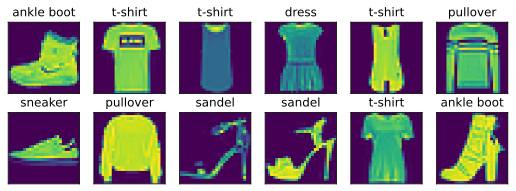

In [4]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root = "./data",train=True,transform=trans,download = True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data",train=False,download=True,transform=trans)

print(len(mnist_train),len(mnist_test))
print(mnist_train[0][0].shape) #第一个维度指定feature,第二个维度指定第几个

def use_svg_display():
    backend_inline.set_matplotlib_formats("svg")

use_svg_display()

def show_labels(labels):
    name_labels = ['t-shirt','trousers','pullover','dress','coat','sandel','shirt','sneaker','bag','ankle boot']
    return [name_labels[int(i)] for i in labels] # 要写int 不然不能正确索引

def show_images(images,num_rows,num_cols,scale=1.5,labels=None):
    figure_size = [num_cols*scale,num_rows*scale]
    _,axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figure_size)
    axes = axes.flatten()
    for i,(axe,image) in enumerate(zip(axes,images)):
        if torch.is_tensor(image):
            axe.imshow(image.numpy())
        else:
            axe.imshow(image)
        axe.axes.get_xaxis().set_visible(False)
        axe.axes.get_yaxis().set_visible(False)
        if labels:
            axe.set_title(labels[i])

X,y = next(iter(data.DataLoader(mnist_train,batch_size=12)))
print(X.shape) # 12*1*28*28
show_images(X.squeeze(),num_rows=2,num_cols=6,labels=show_labels(y))
# 未经训练的labels标注大多数是不对的

In [ ]:
# 这里用一点比较小的篇幅介绍一下‘DataLoader’当中一个比较好玩的属性

import time

def get_dataloader_workers():
    return 2

train_iter = data.DataLoader(mnist_train,shuffle=True,batch_size=256,num_workers=get_dataloader_workers())

class Timer:
    def __init__(self):
        self.time = []
        self.start()

    def start(self):
        self.tik = time.time()
    
    def stop(self):
        self.time.append(time.time()-self.tik)
        return self.time[-1]
    
    def avg(self):
        return sum(self.time) / len(self.time)
    
    def sum(self):
        return sum(self.time)
    
    def cumsum(self):
        return np.array(self.time).cumsum().tolist()

timer = Timer()
for X,y in train_iter:
    continue
print(f"{timer.stop():.2f} secs")
# 当num_workers=4时，时间为2.74s;当num_workers=2时，时间为1.85s
# 当num_workers=0时，表示只使用主进程制造数据集迭代器，当不为0的时候表示引入额外的进程进行读取


1.85 secs


In [10]:
# 这里使用一个集合的函数把前面提到的很多下载数据集、制作dataloader的训练流程整合起来
batch_size = 256 # fashion_mnist训练集的大小为60000，测试集的大小为10000
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",train=True,download=False,transform=trans)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",train=False,download=False,transform=trans)
    return (data.DataLoader(mnist_train,shuffle=True,batch_size=batch_size),data.DataLoader(mnist_test,shuffle=True,batch_size=batch_size))

train_iter, test_iter = load_data_fashion_mnist(batch_size, resize = 64)
for X,y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break



torch.Size([256, 1, 64, 64]) torch.float32 torch.Size([256]) torch.int64


### 3.6 softmax回归的从零开始实现

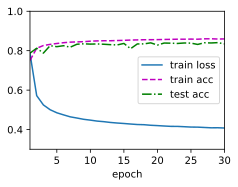

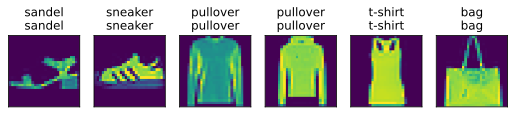

In [6]:
# 接下来正式从零开始，主要包括初始化模型参数、定义softmax、定义模型、定义损失函数、描述分类精度、训练函数、绘图函数、预测函数等等
import torch
import torchvision
from IPython import display
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from torch.utils import data
from torchvision import transforms

# 先照抄一下上面的数据集定义函数
batch_size = 256 
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="./data",train=True,download=False,transform=trans)
    mnist_test = torchvision.datasets.FashionMNIST(root="./data",download=False,train=False,transform=trans)
    return data.DataLoader(mnist_train,shuffle=True,batch_size=batch_size),data.DataLoader(mnist_test,shuffle=True,batch_size=batch_size)

train_iter, test_iter = load_data_fashion_mnist(batch_size)

# 单张FashionMnist图片的大小为28*28,输出10个类别的概率
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01,(784,10),requires_grad=True)
b = torch.zeros(10,requires_grad=True)

# 输出的值不可能满足概率的定义，即单个样本的10个输出加起来为1，且每一个类别输出的值都大于等于0，因此引入softmax操作
X = torch.tensor([[3.0,2.0,1.0],[1.0,1.0,1.0]])
print(X.sum(0,keepdim=True),X.sum(1,keepdim=True))
# 这里输出的两个丈量就是计算softmax概率的基础，这个求和的方式也就是如何归一化输出到概率的方式

def softmax(X):
    '''X为二维张量 第一个维度是样本个数 第二个维度是输出类别个数 因此在第二个维度上求和'''
    exp_x = torch.exp(X)
    sum_exp_x = torch.sum(exp_x,axis=1,keepdim=True)
    return (exp_x / sum_exp_x)

print(softmax(X)) # 验证结果

# 在softmax的基础上定义网络
def net(X):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W) + b) # torch.matmul比torch.mm的用法更灵活，尤其对于多维张量的计算场景


# 前面提到用交叉熵的损失函数是基于真实分布和预测分布计算的，在有softmax可以将输出转换为概率的情况就可以着手如何定义损失函数了
y = torch.tensor([0,2]) # 两个样本的真实类别是0和2
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]]) # y_hat模拟的是两个样本经过网络输出的预测概率
print(y_hat[[0,1],y]) # 输出0.1和0.5 实际上就是预测概率中真正类别的概率

def cross_entropy(y_hat, y):
    return (-1 * torch.log(y_hat[range(len(y_hat)),y])) # 这里没有必要list(range(len(y_hat))),本身range()就是一个迭代对象

print(cross_entropy(y_hat,y)) # 验证结果

# 当输出的概率中最大的那个实际上就是网络判断的预测类别，因此既然有真实类别和预测类别，自然就会有分类是否正确的问题，所以在这个示例中也定义一个计算分类精度的
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1 and len(y_hat.shape) > 1:
        y_hat = y_hat.argmax(axis=1) # torch.tensor的方法
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

print(accuracy(y_hat,y)/len(y)) # 验证结果

# 定义一个实用类，用于记录一些变量并完成累加操作
class Accumulator:
    def __init__(self,n):
        self.data = [0.0] * n
    
    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data,args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]
    
# 在Accumulator类的基础上定义记录预测精度的函数
def evaluate_accuracy(net, data_iter):
    '''Accumulator实例中第一个记录的是预测正确的样本数 第二个记录的是总的样本数'''
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return (metric[0] / metric[1])

# 接下来定义训练的专用函数
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric = Accumulator(3) # Accumulator实例中有三个变量，第一个记录单次epoch中所有的loss和，第二个记录预测正确的样本数，第三个记录总的样本数
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward() # 这里传入sum()的主要原因是我们自定义的sgd是除了一个batch_size的，并且sgd函数中有梯度清零的操作
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2], metric[1]/metric[2]

# 这里有一个在d2l包中定义的绘制专用类，可以直接用现成的，也可以重新在这里定义
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    if legend:
        axes.legend(legend)

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None,
                 xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                 figsize=(3.5,2.5)):
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda:set_axes(
            self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend
        )
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self,x,y):
        if not hasattr(y,"__len__"):
            y = [y]
        n = len(y)
        if  not hasattr(x,"__len__"):
            x = [x] * n
        # self.X和self.Y这两个类其实是为了画出loss和在训练集和测试集上随着训练epoch的变化情况，因此长度就是3
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y,fmt in zip(self.X,self.Y,self.fmts):
            self.axes[0].plot(x,y,fmt)
        self.config_axes() # 灵活运用lambda函数省去重复使用复杂函数
        display.display(self.fig)
        display.clear_output(wait=True) # display这个模块的引入主要是为了动态画出变化的过程 直接plot + show 无法实现这种动态变化的效果

# 上面的绘画类实际上画出的是多个epoch之间的变化情况，因此在实现单次训练迭代的基础上定义总的训练函数

lr = 0.1

def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

def updater(batch_size):
    return sgd([W,b],lr,batch_size)

def train_ch3(net, train_iter, test_iter, loss ,num_epochs, updater):
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,1.0],legend=["train loss", 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater)
        test_acc = evaluate_accuracy(net,test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <=1 and train_acc > 0.7, train_acc
    assert test_acc <=1 and test_acc > 0.7, test_acc # 判断一下特殊情况

num_epochs = 30
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

# 训练完成后，我们可以运用训练结束的网络进行预测，这里用到了前面的显示图片和类别的函数

def show_labels(labels):
    name_labels = ['t-shirt','trousers','pullover','dress','coat','sandel','shirt','sneaker','bag','ankle boot']
    return [name_labels[int(i)] for i in labels] # 要写int 不然不能正确索引

def show_images(images,num_rows,num_cols,scale=1.5,labels=None):
    figure_size = [num_cols*scale,num_rows*scale]
    _,axes = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figure_size)
    axes = axes.flatten()
    for i,(axe,image) in enumerate(zip(axes,images)):
        if torch.is_tensor(image):
            axe.imshow(image.numpy())
        else:
            axe.imshow(image)
        axe.axes.get_xaxis().set_visible(False)
        axe.axes.get_yaxis().set_visible(False)
        if labels:
            axe.set_title(labels[i])

def predict_ch3(net, test_iter, n=6):
    for X,y in test_iter:
        break
    trues = show_labels(y)
    preds = show_labels(net(X).argmax(axis=1))
    titles = [true+"\n"+pred for true,pred in zip(trues,preds)]
    show_images(X.squeeze(),1,n,labels=titles[0:n])

predict_ch3(net, test_iter)

#### 3.7 softmax回归的简洁实现

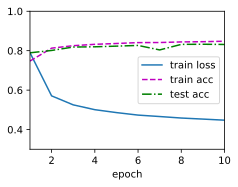

In [8]:
# 上面我们用很大的代码量从头写了模型的所有部件，但其实很多的代码可以复用(例如画图、显示结果、存储数据的类和函数),但更重要的是可以通过现成的pytorch封装的函数来实现网络

import torch
from torch import nn

batch_size = 256 
train_iter, test_iter = load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(784,10)) # 前面的Flatten起到了一个将二维图像转换为一维的作用
# 一般来说输入的图片维度都是(batch_size,channels,height,width)，Flatten的作用是将除第一维度的全部放在一个维度中


# d2l在这里介绍了重新看待softmax和crossentropy两个部分的计算过程，提到了计算softmax计算可能出现的上溢和下溢的问题，通过引入交叉熵的对数计算，从而可以通过
loss = nn.CrossEntropyLoss(reduction="none") # reduction指定了loss的处理方式，"none"/"mean"/"sum"
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)